In [1]:
import os
import sys
sys.path.insert(0, os.getcwd())

import torch
import random
from omegaconf import DictConfig
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

import numpy as np

from tsl import logger
from tsl.data import ImputationDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PeMS07, PvUS, LargeST, ElectricityBenchmark, Elergone
from tsl.engines import Imputer
from tsl.experiment import Experiment
from tsl.metrics import numpy as numpy_metrics
from tsl.metrics import torch as torch_metrics
from tsl.nn.models import (BiRNNImputerModel, GRINModel, RNNImputerModel,
                           SPINHierarchicalModel, SPINModel)
from tsl.transforms import MaskInput
from tsl.utils.casting import torch_to_numpy

from my_datasets import AirQualitySmaller, AirQualityAuckland, AirQualityKrig, add_missing_sensors
from baselines.KITS import KITS
from baselines.IGNNK import IGNNK

from fillers.KITS_filler import GCNCycVirtualFiller
from fillers.unnamed_filler import UnnamedKrigFiller
from fillers.unnamed_filler_v2 import UnnamedKrigFillerV2
from unnamedKrig import UnnamedKrigModel
from unnamedKrig_v2 import UnnamedKrigModelV2
from unnamedKrig_v3 import UnnamedKrigModelV3
from utils import classical_mds_with_inf

from omegaconf import OmegaConf

import matplotlib.pyplot as plt

from torch_geometric.utils import dense_to_sparse, get_ppr
from my_datasets import AirQualitySmaller, AirQualityAuckland, AirQualityKrig, add_missing_sensors
import networkx as nx

In [2]:
from torch_scatter import scatter

def l2diff(x1, x2):
    """
    standard euclidean norm
    """
    sum_of_diff_square = ((x1-x2)**2).sum(-1) + 1e-8
    return sum_of_diff_square.sqrt()


def moment_diff(sx1, sx2, k, og_batch, coarse_batch):
    """
    difference between moments
    """
    ss1 = scatter(sx1**k, og_batch, dim=0, dim_size=None, reduce='mean')
    ss2 = scatter(sx2**k, coarse_batch, dim=0, dim_size=None, reduce='mean')
    return l2diff(ss1,ss2)

def cmd(x1, x2, og_batch, coarse_batch, n_moments=5):
    """
    central moment discrepancy (cmd)
    - Zellinger, Werner et al. "Robust unsupervised domain adaptation
    for neural networks via moment alignment," arXiv preprint arXiv:1711.06114,
    2017.
    - Zellinger, Werner, et al. "Central moment discrepancy (CMD) for
    domain-invariant representation learning.", ICLR, 2017.
    """
    #print("input shapes", x1.shape, x2.shape)
    mx1 = scatter(x1, og_batch, dim=0, dim_size=None, reduce='mean')
    mx2 = scatter(x2, coarse_batch, dim=0, dim_size=None, reduce='mean')
    print("mx* shapes should be same (batch_szie, dim)", mx1.shape, mx2.shape)
    print(mx1.repeat_interleave(torch.unique(og_batch, return_counts=True)[1], dim=0))
    print(mx1)
    sx1 = x1 - mx1.repeat_interleave(torch.unique(og_batch, return_counts=True)[1], dim=0)
    sx2 = x2 - mx2.repeat_interleave(torch.unique(coarse_batch, return_counts=True)[1], dim=0)
    print("sx1, sx2 should be same size as input", sx1.shape, sx2.shape)
    dm = l2diff(mx1, mx2)
    print("dm should have shape (batch_size,)", dm.shape)
    scms = dm
    for i in range(n_moments-1):
        # moment diff of centralized samples
        scms = scms + moment_diff(sx1, sx2, i+2, og_batch, coarse_batch)
    return scms

x1 = torch.rand((5, 10))
x2 = torch.rand((5, 10))

og_batch = torch.tensor([0, 0, 0, 1, 1])
coarse_batch = torch.tensor([0, 0, 0, 1, 1])

cmd(x1, x2, og_batch, coarse_batch)

mx* shapes should be same (batch_szie, dim) torch.Size([2, 10]) torch.Size([2, 10])
tensor([[0.3542, 0.3357, 0.5700, 0.7440, 0.3163, 0.4620, 0.4219, 0.4536, 0.7012,
         0.6228],
        [0.3542, 0.3357, 0.5700, 0.7440, 0.3163, 0.4620, 0.4219, 0.4536, 0.7012,
         0.6228],
        [0.3542, 0.3357, 0.5700, 0.7440, 0.3163, 0.4620, 0.4219, 0.4536, 0.7012,
         0.6228],
        [0.1436, 0.3977, 0.6173, 0.4304, 0.5673, 0.3506, 0.6761, 0.5792, 0.3352,
         0.6106],
        [0.1436, 0.3977, 0.6173, 0.4304, 0.5673, 0.3506, 0.6761, 0.5792, 0.3352,
         0.6106]])
tensor([[0.3542, 0.3357, 0.5700, 0.7440, 0.3163, 0.4620, 0.4219, 0.4536, 0.7012,
         0.6228],
        [0.1436, 0.3977, 0.6173, 0.4304, 0.5673, 0.3506, 0.6761, 0.5792, 0.3352,
         0.6106]])
sx1, sx2 should be same size as input torch.Size([5, 10]) torch.Size([5, 10])
dm should have shape (batch_size,) torch.Size([2])


tensor([0.9051, 1.2271])

In [3]:
from einops import rearrange

test = torch.rand((2, 5, 10))
test2 = rearrange(test, 'b n d -> (b n) d')
test

tensor([[[0.0531, 0.3736, 0.2647, 0.7116, 0.1682, 0.2695, 0.9112, 0.9195,
          0.2640, 0.8344],
         [0.0816, 0.6986, 0.6630, 0.0997, 0.6228, 0.1304, 0.1684, 0.6123,
          0.8454, 0.7686],
         [0.6198, 0.9897, 0.1363, 0.5208, 0.5913, 0.6268, 0.1857, 0.7633,
          0.6004, 0.5013],
         [0.1733, 0.8056, 0.2883, 0.0624, 0.0692, 0.6191, 0.9632, 0.4727,
          0.4846, 0.7267],
         [0.8509, 0.8307, 0.0857, 0.0407, 0.1598, 0.1226, 0.2334, 0.9420,
          0.9359, 0.8447]],

        [[0.2726, 0.0637, 0.1775, 0.5935, 0.9703, 0.8025, 0.5758, 0.9729,
          0.1361, 0.7086],
         [0.1020, 0.7553, 0.9079, 0.5363, 0.0933, 0.1912, 0.8293, 0.8503,
          0.6640, 0.9004],
         [0.6094, 0.0884, 0.1315, 0.3986, 0.5258, 0.9093, 0.9592, 0.4541,
          0.9141, 0.8505],
         [0.4116, 0.1069, 0.6007, 0.4221, 0.4237, 0.8589, 0.3172, 0.3337,
          0.7229, 0.6592],
         [0.4370, 0.6478, 0.8994, 0.4736, 0.8021, 0.3703, 0.7918, 0.9961,
          0.931

In [22]:
batches = torch.arange(0, 2)
torch.repeat_interleave(batches, repeats=(5))

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [3]:
MODELS = ['kits', 'unkrig', 'kcn', 'unkrigv2', 'unkrigv3', 'ignnk']

def get_model_class(model_str):
    if model_str == 'rnni':
        model = RNNImputerModel
    elif model_str == 'birnni':
        model = BiRNNImputerModel
    elif model_str == 'grin':
        model = GRINModel
    elif model_str == 'spin':
        model = SPINModel
    elif model_str == 'spin-h':
        model = SPINHierarchicalModel
    elif model_str == 'kits':
        model = KITS
    elif model_str == 'unkrig':
        model = UnnamedKrigModel
    elif model_str == 'unkrigv2':
        model = UnnamedKrigModelV2
    elif model_str == 'unkrigv3':
        model = UnnamedKrigModelV3
    elif model_str == 'ignnk':
        model = IGNNK
    else:
        raise NotImplementedError(f'Model "{model_str}" not available.')
    return model


def get_dataset(dataset_name: str, p_fault=0., p_noise=0., t_range = ['2022-04-01', '2022-12-01'],
                masked_s=None, agg_func = 'mean', test_month=[5], location='Auckland', connectivity=None, mode='road'):
    if dataset_name == 'air':
        return AirQualityKrig(impute_nans=True, small=True, masked_sensors=masked_s, p=p_noise), masked_s
    if dataset_name == 'air_smaller':
        return AirQualitySmaller('../../AirData/AQI/Stations', impute_nans=True, masked_sensors=masked_s), masked_s
    if dataset_name == 'air_auckland' or dataset_name == 'air_invercargill1' or dataset_name == 'air_invercargill2':
        return AirQualityAuckland('../../AirData/Niwa', t_range=t_range, masked_sensors=masked_s, 
                                  agg_func=agg_func, test_months=test_month,
                                  location=location, p=p_noise), masked_s
    if dataset_name.endswith('_point'):
        p_fault, p_noise = 0., 0.25
        dataset_name = dataset_name[:-6]
    if dataset_name.endswith('_block'):
        p_fault, p_noise = 0.0015, 0.05
        dataset_name = dataset_name[:-6]
    if dataset_name == 'metrla':
        return add_missing_sensors(MetrLA(freq='5T'),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4, 
                                  masked_sensors=masked_s,
                                  connect=connectivity,
                                  mode=mode)
    if dataset_name == 'pem07':
        pems = PeMS07()

        masks = np.ones((pems.target.shape[0], pems.target.shape[1], 1))
        pems.set_mask(masks)
        
        return add_missing_sensors(pems,
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  masked_sensors=masked_s,
                                  connect=connectivity,
                                  mode=mode)

    if dataset_name == 'aqi':
        pems = AirQuality(test_months=test_month)

        masks = np.ones((pems.target.shape[0], pems.target.shape[1], 1))
        pems.set_mask(masks)
        
        return add_missing_sensors(pems,
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  masked_sensors=masked_s,
                                  connect=connectivity,
                                  mode=mode)

    if dataset_name == 'nrel':
        pv_us = PvUS(zones='east')
        pv_us.metadata = pv_us.metadata[:137]
        cols = pv_us.target.columns[:137]
        pv_us.target = pv_us.target.loc[:, cols]

        masks = np.ones((pv_us.target.shape[0], pv_us.target.shape[1], 1))
        pv_us.set_mask(masks)
        
        return add_missing_sensors(pv_us,
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  masked_sensors=masked_s,
                                  connect=connectivity,
                                  mode=mode)
    
    if dataset_name == 'sd':
        return add_missing_sensors(LargeST(subset='SD', year=[2019, 2020]),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  masked_sensors=masked_s,
                                  connect=connectivity,
                                  mode=mode)

    if dataset_name == 'electricity':
        return add_missing_sensors(ElectricityBenchmark(),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  masked_sensors=masked_s,
                                  connect=connectivity,
                                  mode=mode)

    raise ValueError(f"Dataset {dataset_name} not available in this setting.")

In [3]:
# mask_s = [0, 4, 5, 6, 10, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 29, 31, 32]
mask_s = [26, 126, 200, 21, 121, 18, 189, 50, 35, 182, 181, 180, 186, 59, 150, 8, 34, 185, 46, 66, 203, 149, 87, 100, 14, 86, 104, 112, 89, 151, 148, 172, 88, 202, 9, 51, 84, 204, 130, 41, 197, 77, 194, 43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
# mask_s= [1, 2, 3, 4, 5, 6]
mask_s = None

# mask_s = [1, 8, 9, 21, 35]
# mask_s = [0, 5, 18, 19, 31]

dataset, masked_sensors = get_dataset('metrla', p_noise=0.25, masked_s=mask_s, mode = 'region', connectivity={'method': 'distance', 'threshold': 0.7, 'include_self': False})
# covariates = {'u': dataset.datetime_encoded('day').values}
# adj = dataset.get_connectivity()

In [4]:
import os

def load_model_and_infer(og_path: str, index):
    torch.set_float32_matmul_precision('high')
    
    result = []
    for root, dirs, files in os.walk(og_path):
        for name in files:
            if 'ckpt' in name:
                result.append(os.path.join(root, name))
    
    assert len(result)
    print(result)
    checkpoint_path = result[index]
    
    # Load configuration
    cfg = OmegaConf.load(os.path.join(og_path, 'config.yaml'))
    print(cfg.seed)
    torch.manual_seed(cfg.seed)
    np.random.seed(cfg.seed)
    random.seed(cfg.seed)
    
    # Load dataset
    dataset, masked_sensors = get_dataset(cfg.dataset.name,
                            p_fault=cfg.dataset.get('p_fault'),
                            p_noise=cfg.dataset.get('p_noise'),
                            t_range=cfg.dataset.get('t_range'),
                            masked_s=cfg.dataset.get('masked_sensors'),
                            agg_func=cfg.dataset.get('agg_func'),
                            test_month=cfg.dataset.get('test_month'),
                            location=cfg.dataset.get('location'),
                            connectivity=cfg.dataset.get('connectivity'),
                            mode=cfg.dataset.get('mode'))
    print(f'Masked sensors: {masked_sensors}')
    # covariates = {'u': dataset.datetime_encoded('day').values}

    if cfg.model.name in MODELS:
        adj = dataset.get_connectivity(**cfg.dataset.connectivity, layout='dense')
    else:
        adj = dataset.get_connectivity(**cfg.dataset.connectivity)
    
    torch_dataset = ImputationDataset(
        target=dataset.dataframe(),
        mask=dataset.training_mask,
        eval_mask=dataset.eval_mask,
        # covariates=covariates,
        transform=MaskInput(),
        connectivity=adj,
        window=cfg.window,
        stride=cfg.stride
    )
    
    scalers = {'target': StandardScaler(axis=(0, 1))}

    dm = SpatioTemporalDataModule(
        dataset=torch_dataset,
        scalers=scalers,
        splitter=dataset.get_splitter(**cfg.dataset.splitting),
        batch_size=cfg.batch_size,
        workers=cfg.workers)
    
    dm.setup(stage='test')
    
    # Load model
    model_cls = get_model_class(cfg.model.name)
    
    if cfg.model.name == 'kits':
        model_kwargs = dict(adj=adj, d_in=dm.n_channels, n_nodes=dm.n_nodes, args=cfg.model)
    elif cfg.model.name == 'unkrig':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'unkrigv2':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'unkrigv3':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'ignnk':
        model_kwargs = dict(z=cfg.model.z, h=cfg.window, K=cfg.model.K)
    elif cfg.model.name == 'kcn':
        pass
    else:
        model_kwargs = dict(n_nodes=torch_dataset.n_nodes,
                            input_size=torch_dataset.n_channels)
        
    model_cls.filter_model_args_(model_kwargs)
    model_kwargs.update(cfg.model.hparams)
    print(cfg.device)
    trainer = Trainer(
        max_epochs=cfg.epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=cfg.device,
        gradient_clip_val=cfg.grad_clip_val,
        gradient_clip_algorithm=cfg.grad_clip_alg,)
    
    print(model_cls)
    
    if cfg.model.name == 'kits':
        imputer = GCNCycVirtualFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs,
                                                            gradient_clip_val=cfg.grad_clip_val,
                                                            gradient_clip_algorithm=cfg.grad_clip_alg,
                                                            known_nodes = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                                            **cfg.model.technique)
    elif cfg.model.name == "unkrig":
        imputer = UnnamedKrigFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                    model_kwargs=model_kwargs,
                                    gradient_clip_val=cfg.grad_clip_val,
                                    gradient_clip_algorithm=cfg.grad_clip_alg,
                                    known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                    **cfg.model.regs)
    elif cfg.model.name == "unkrigv2" or cfg.model.name == "unkrigv3":
        imputer = UnnamedKrigFillerV2.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                    model_kwargs=model_kwargs,
                                    gradient_clip_val=cfg.grad_clip_val,
                                    gradient_clip_algorithm=cfg.grad_clip_alg,
                                    known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                    **cfg.model.regs)
    else:
        imputer = Imputer.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs)

    imputer.eval()

    # trainer.test(imputer, datamodule=dm)
    
    # # Run inference
    # trainer = torch.utils.data.DataLoader(dm.test_dataloader(), batch_size=cfg.batch_size)
    output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
    output = imputer.collate_prediction_outputs(output)
    output = torch_to_numpy(output)
    
    y_hat, y_true, mask, adj_invar, adj_var, sum_out = (output['y_hat'], output['y'],
                                                        output.get('eval_mask', None),
                                                        output.get('inv_adj', None),
                                                        output.get('var_adj', None),
                                                        output.get('sum_out', None))
    # mask[:, :, 12, :] = 0
    # mask[:, :, 4, :] = True
    res = dict(test_mae=numpy_metrics.mae(y_hat, y_true, mask),
               test_mre=numpy_metrics.mre(y_hat, y_true, mask),
               test_mape=numpy_metrics.mape(y_hat, y_true, mask),
               test_rmse=numpy_metrics.rmse(y_hat, y_true, mask))

    # return output[-2], output[-1]
    
    return y_hat, y_true, mask, res, dm, dataset, model_cls, adj_invar, adj_var, sum_out


In [7]:
# paths = ['../logs/kits/metrla/2025-04-03/transfer1']
paths = ['../logs/unkrig/air/2025-04-09/15-08-32']
paths = ['../logs/kits/metrla/2025-04-03/14-28-14', '../logs/unkrig/metrla/2025-04-16/17-24-43']
paths = ['../logs/unkrig/air/2025-05-02/15-59-51', '../logs/kits/air/2025-05-02/00-40-52']
# paths = ['../logs/unkrig/metrla/2025-04-29/11-54-31', '../logs/kits/metrla/2025-04-21/14-44-49']
# paths = ['../logs/unkrig/air/2025-05-07/15-36-40', '../logs/kits/air/2025-05-02/00-40-52']
paths = ['../logs/unkrig/metrla/2025-05-07/23-28-11', '../logs/kits/metrla/2025-05-14/15-07-38']
paths = ['../logs/unkrigv2/metrla/2025-05-18/21-02-53']
paths = ['../logs/unkrigv3/metrla/2025-05-26/20-49-12', '../logs/kits/metrla/2025-05-18/20-49-18']
# paths = ['../logs/unkrigv3/air/2025-05-23/15-38-02', '../logs/kits/air/2025-05-23/16-53-39', '../logs/unkrigv3/air/2025-05-20/22-57-47']
# paths = ['../logs/unkrigv3/air/2025-05-26/20-03-12', '../logs/kits/air/2025-05-23/16-53-39']

deets = []
# for path in paths:
res = load_model_and_infer(paths[0], 0)
deets.append(res)
print(res[3])
res = load_model_and_infer(paths[1], 0)
deets.append(res)
print(res[3])

# for path in paths:
#     res = load_model_and_infer(path, 1)
#     deets.append(res)
#     print(res[3])

# deets[3] = load_model_and_infer(paths[3])

['../logs/unkrigv3/metrla/2025-05-26/20-49-12/epoch=86-step=33408.ckpt', '../logs/unkrigv3/metrla/2025-05-26/20-49-12/epoch=90-last.ckpt']
16849815


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [3, 4, 5, 6, 12, 15, 16, 17, 19, 20, 22, 32, 33, 39, 57, 67, 68, 71, 72, 74, 80, 91, 93, 94, 96, 97, 98, 102, 103, 118, 119, 124, 127, 128, 136, 138, 144, 154, 155, 157, 159, 160, 161, 162, 163, 166, 175, 187, 188, 190, 191, 192, 193, 195, 196, 198, 205, 206]
[3]
<class 'unnamedKrig_v3.UnnamedKrigModelV3'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:22<00:00,  4.88it/s]
{'test_mae': np.float32(11.542583), 'test_mre': np.float32(0.20992152), 'test_mape': np.float32(0.43969798), 'test_rmse': np.float32(17.46546)}
['../logs/kits/metrla/2025-05-18/20-49-18/epoch=63-step=24576.ckpt', '../logs/kits/metrla/2025-05-18/20-49-18/epoch=99-last.ckpt']
16849815


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [3, 4, 5, 6, 12, 15, 16, 17, 19, 20, 22, 32, 33, 39, 57, 67, 68, 71, 72, 74, 80, 91, 93, 94, 96, 97, 98, 102, 103, 118, 119, 124, 127, 128, 136, 138, 144, 154, 155, 157, 159, 160, 161, 162, 163, 166, 175, 187, 188, 190, 191, 192, 193, 195, 196, 198, 205, 206]
[1]
<class 'baselines.KITS.KITS'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:17<00:00,  6.25it/s]
{'test_mae': np.float32(10.427237), 'test_mre': np.float32(0.18963704), 'test_mape': np.float32(0.40133086), 'test_rmse': np.float32(16.185246)}


(6849, 24, 207, 1)
(6849, 24, 207, 1)


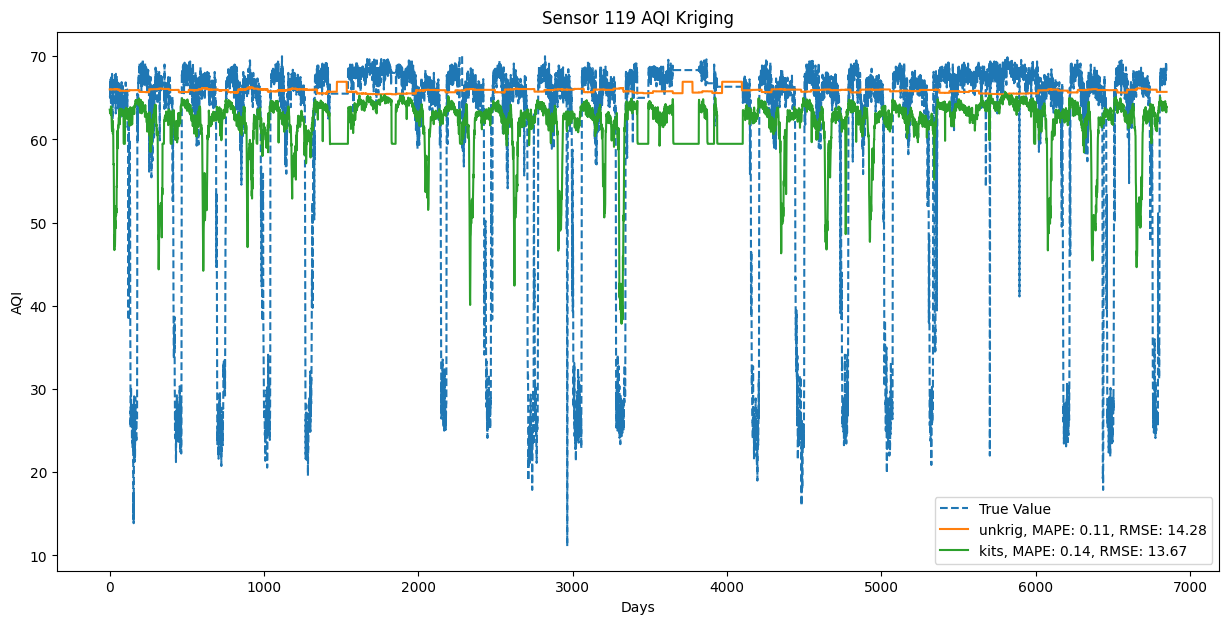

(6849, 24, 207, 1)
(6849, 24, 207, 1)


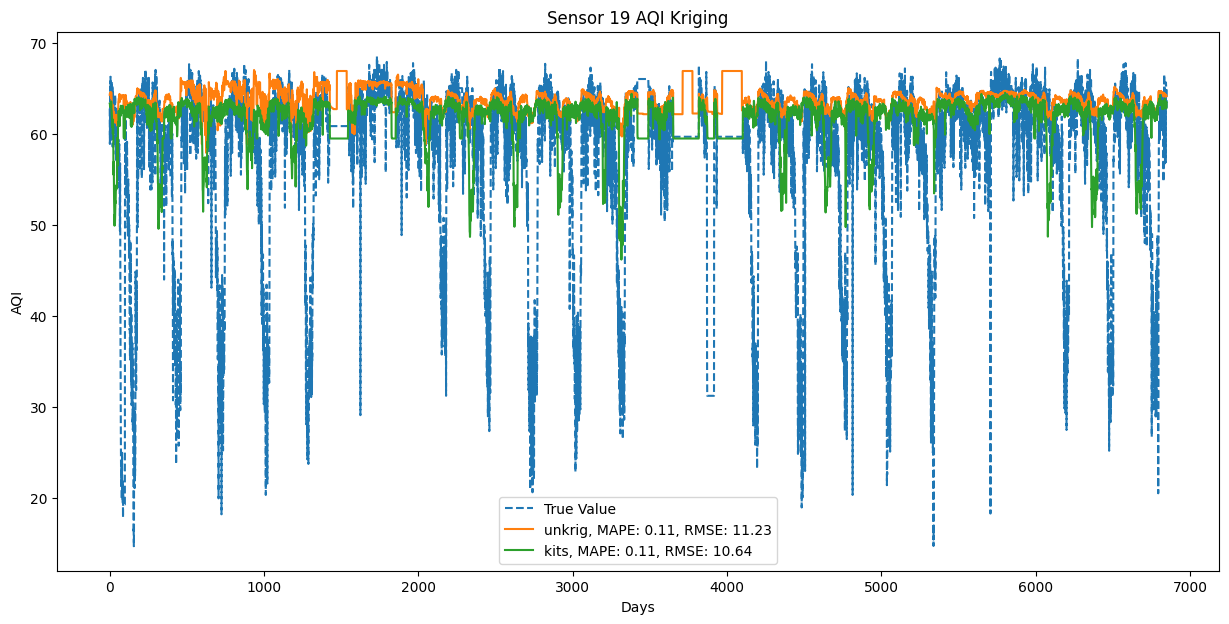

(6849, 24, 207, 1)
(6849, 24, 207, 1)


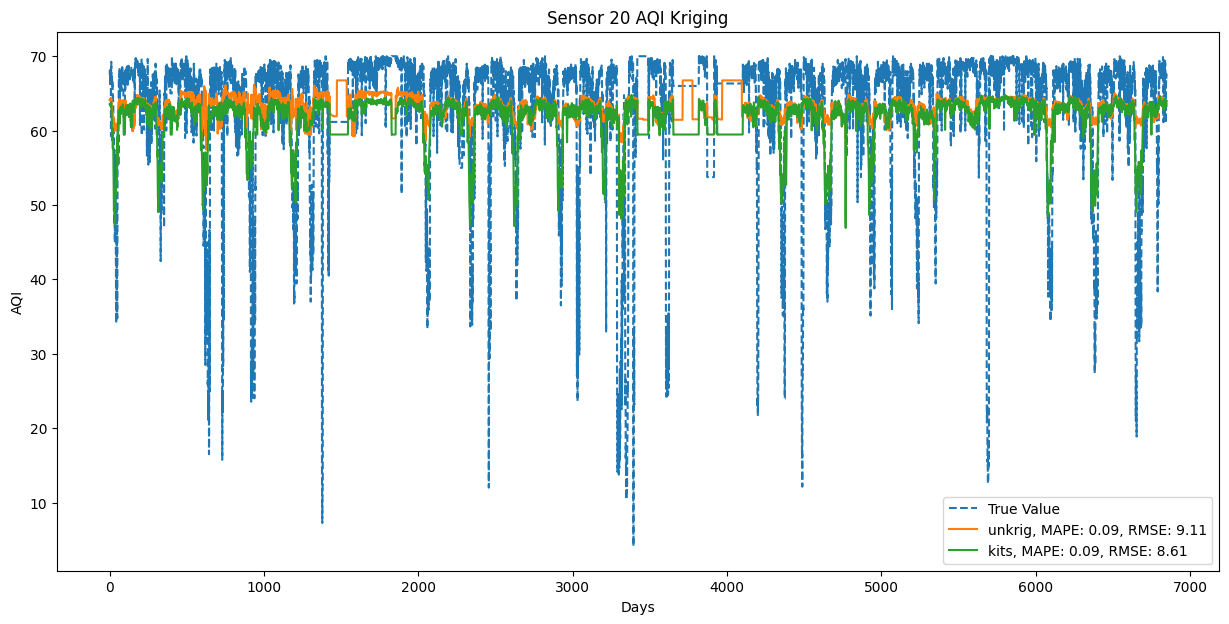

(6849, 24, 207, 1)
(6849, 24, 207, 1)


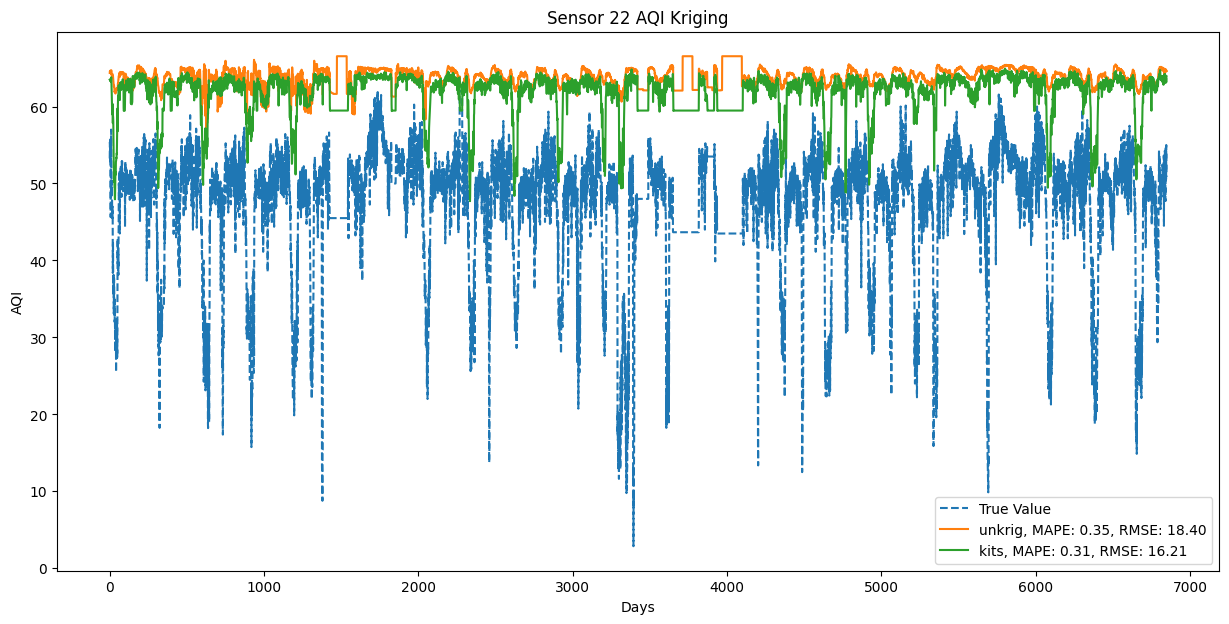

(6849, 24, 207, 1)
(6849, 24, 207, 1)


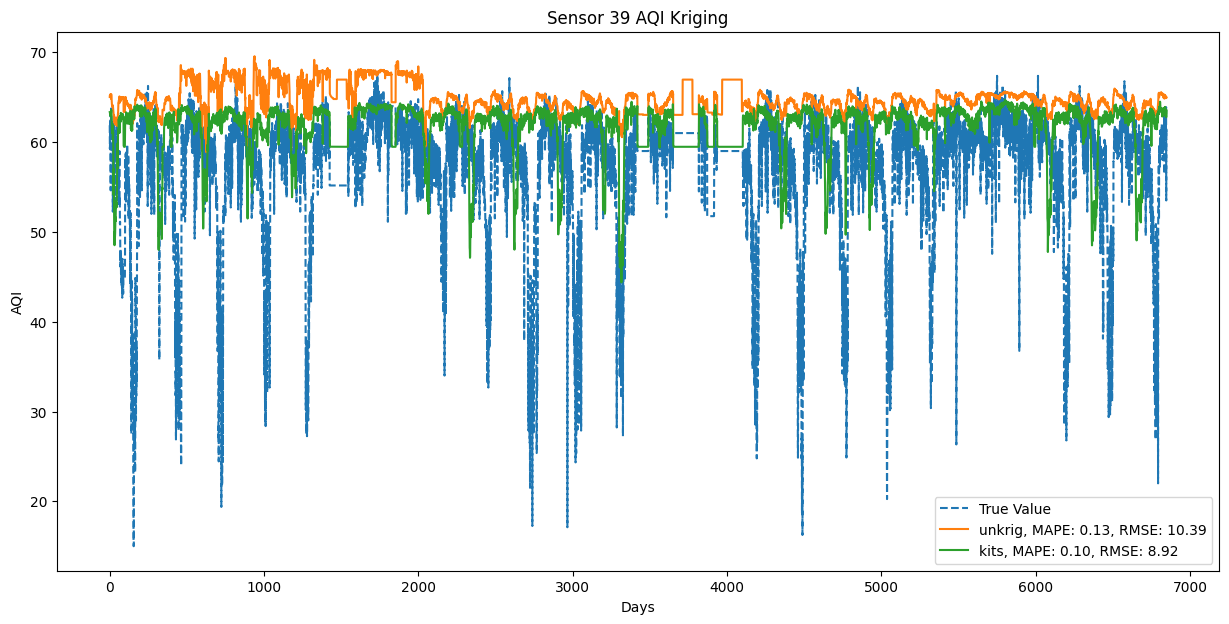

(6849, 24, 207, 1)
(6849, 24, 207, 1)


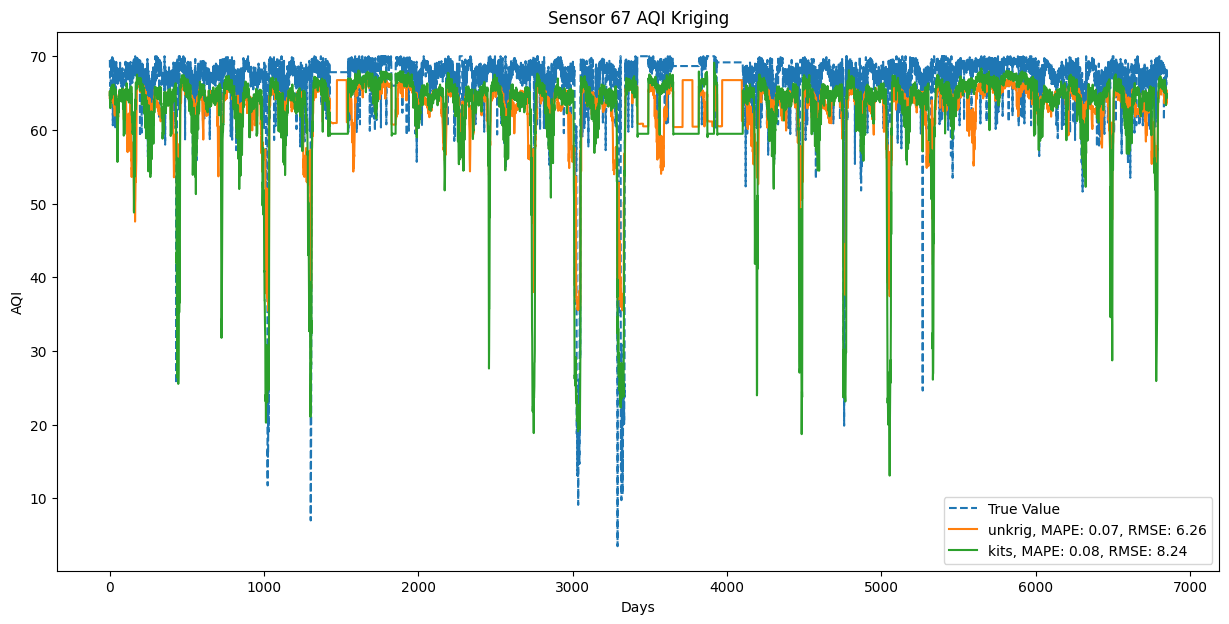

(6849, 24, 207, 1)
(6849, 24, 207, 1)


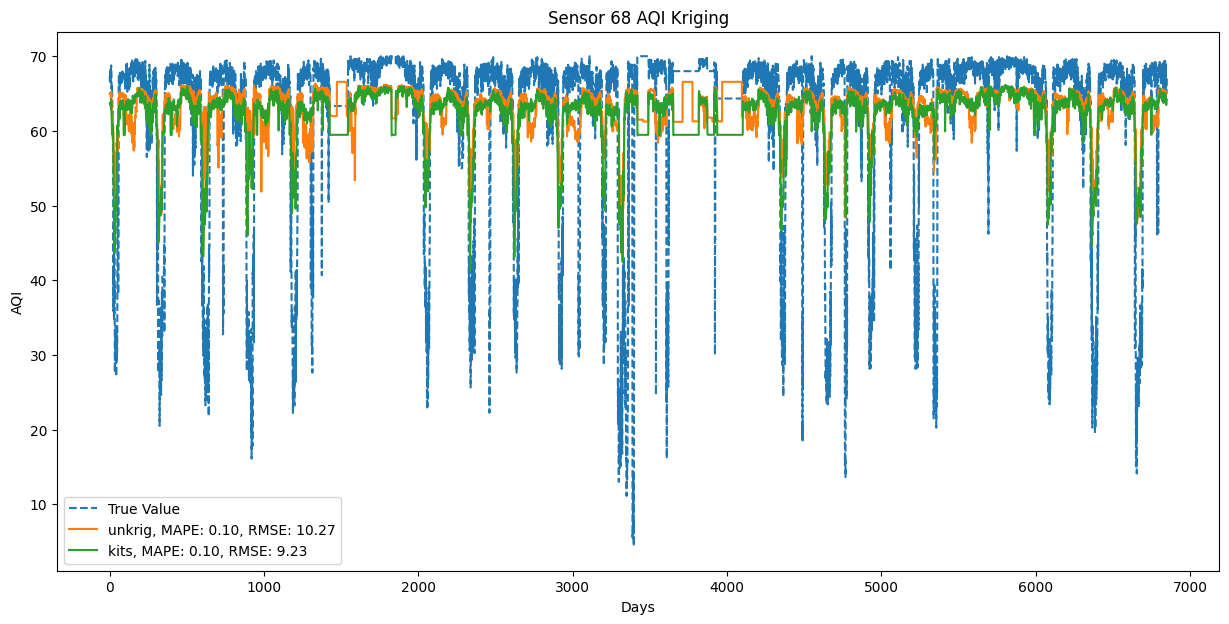

(6849, 24, 207, 1)
(6849, 24, 207, 1)


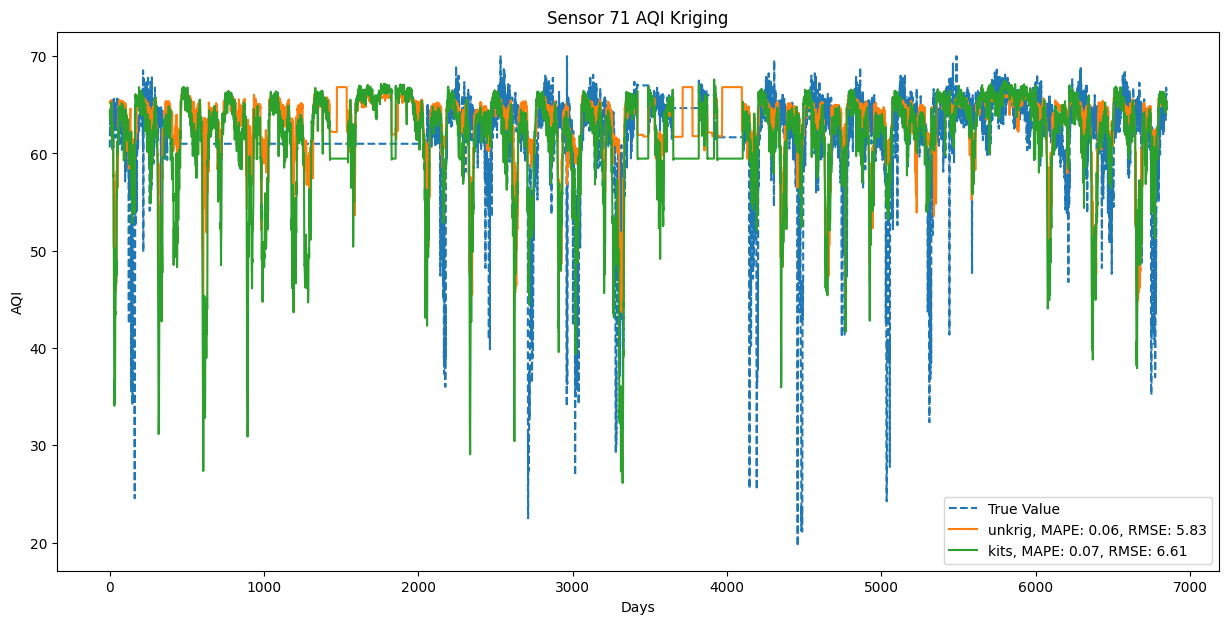

(6849, 24, 207, 1)
(6849, 24, 207, 1)


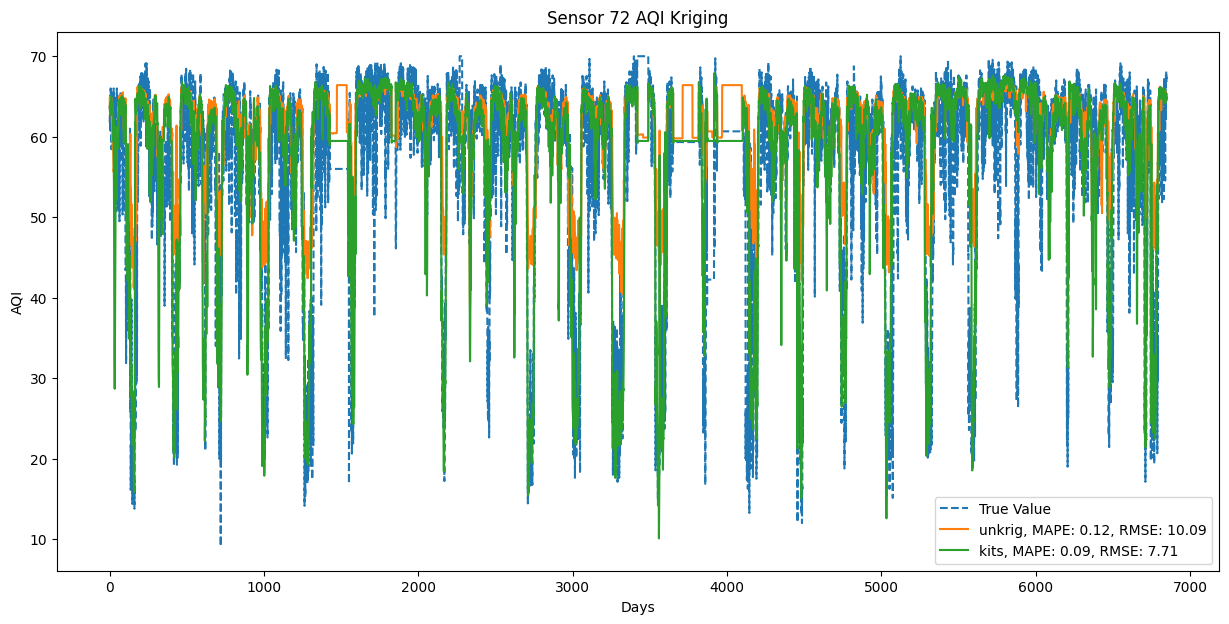

(6849, 24, 207, 1)
(6849, 24, 207, 1)


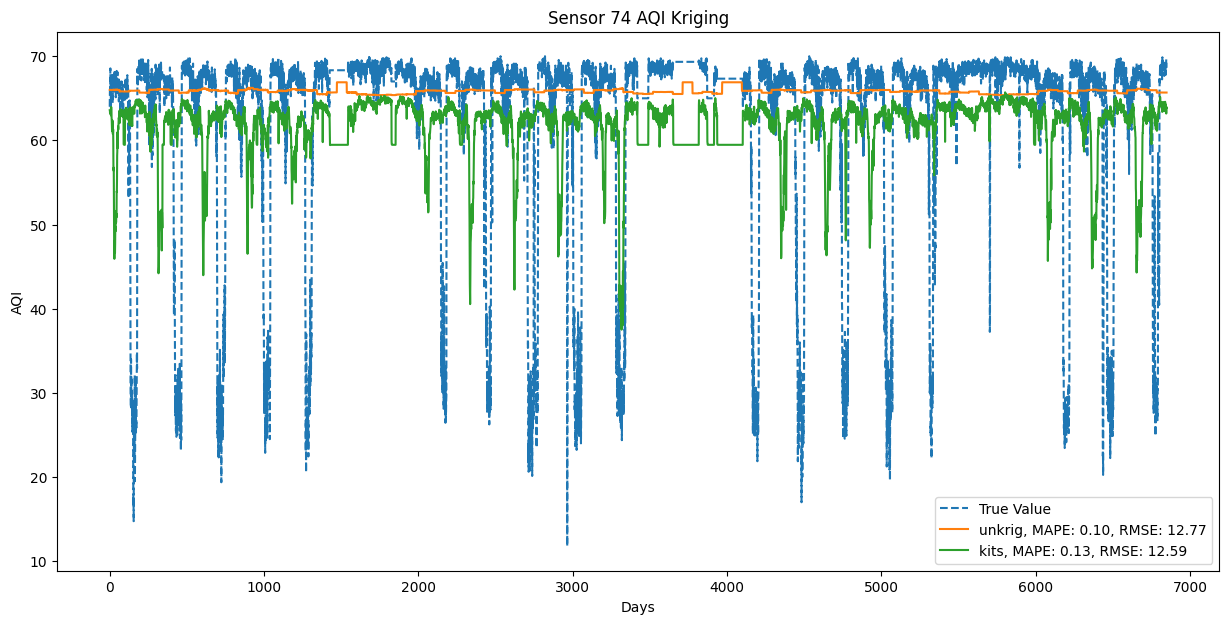

(6849, 24, 207, 1)
(6849, 24, 207, 1)


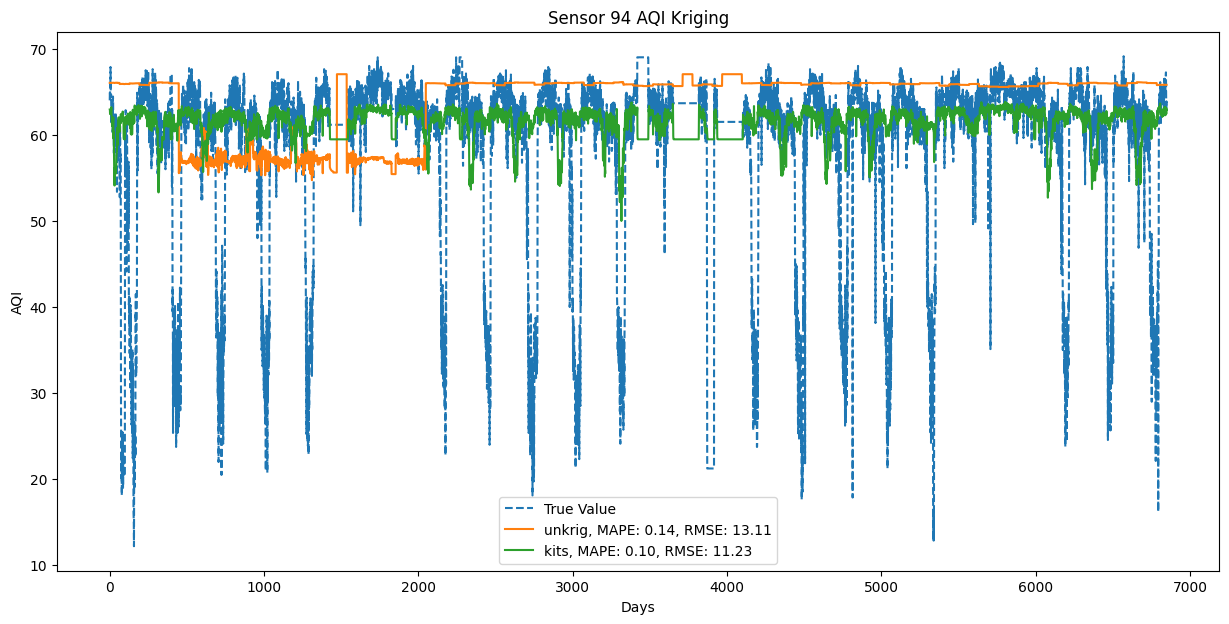

(6849, 24, 207, 1)
(6849, 24, 207, 1)


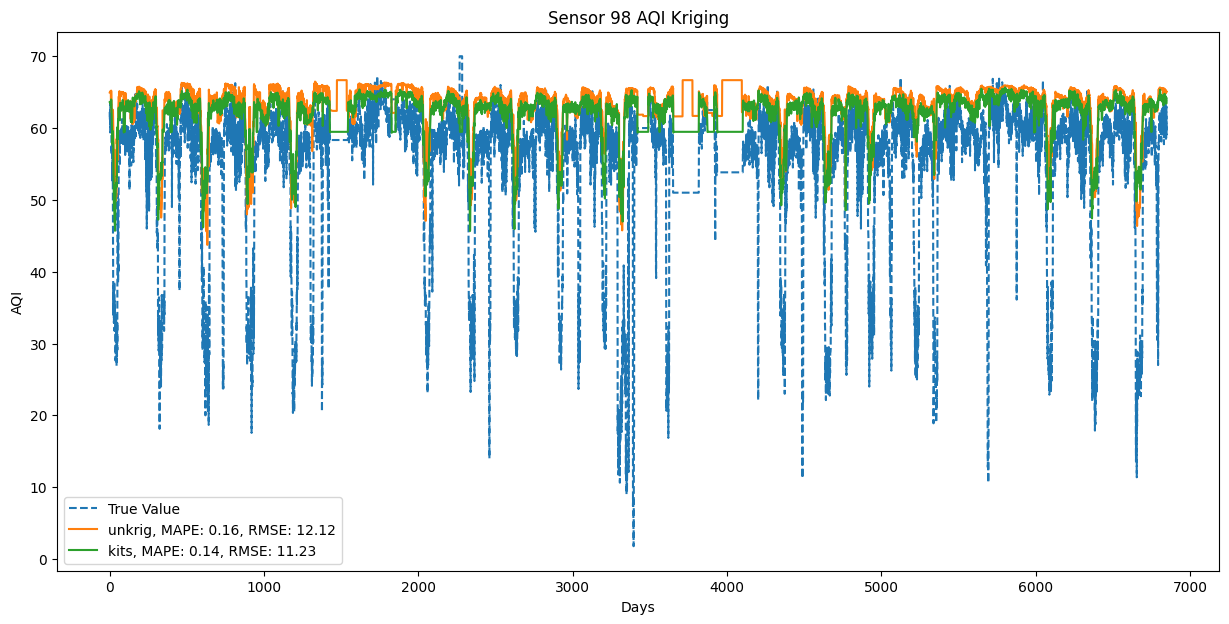

(6849, 24, 207, 1)
(6849, 24, 207, 1)


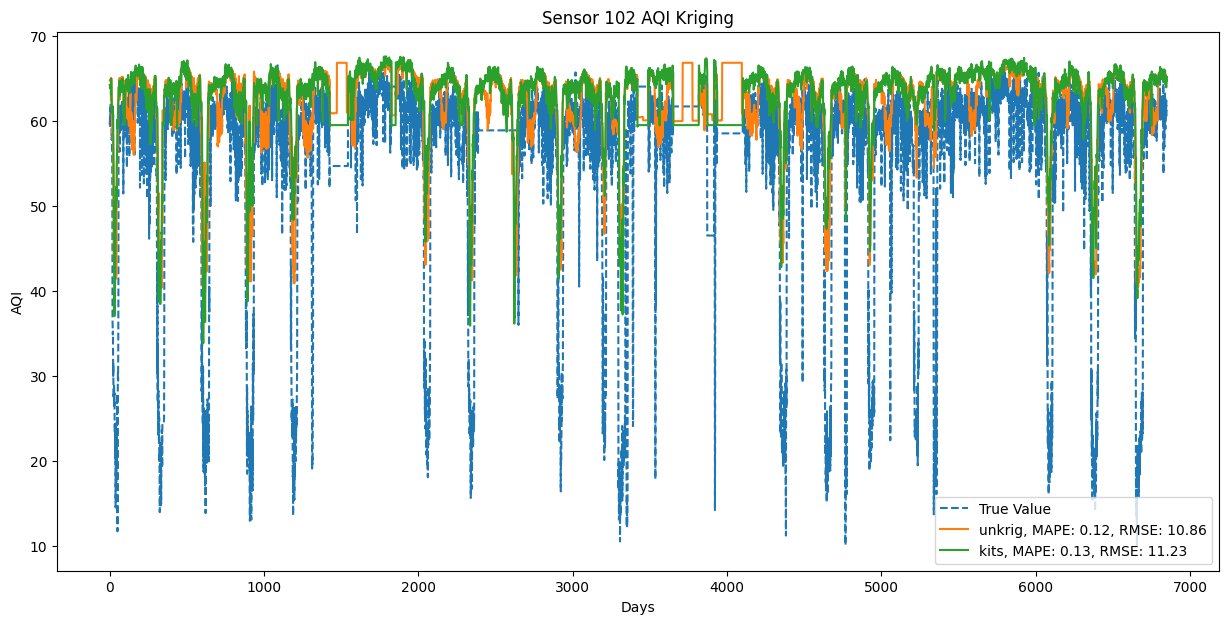

(6849, 24, 207, 1)
(6849, 24, 207, 1)


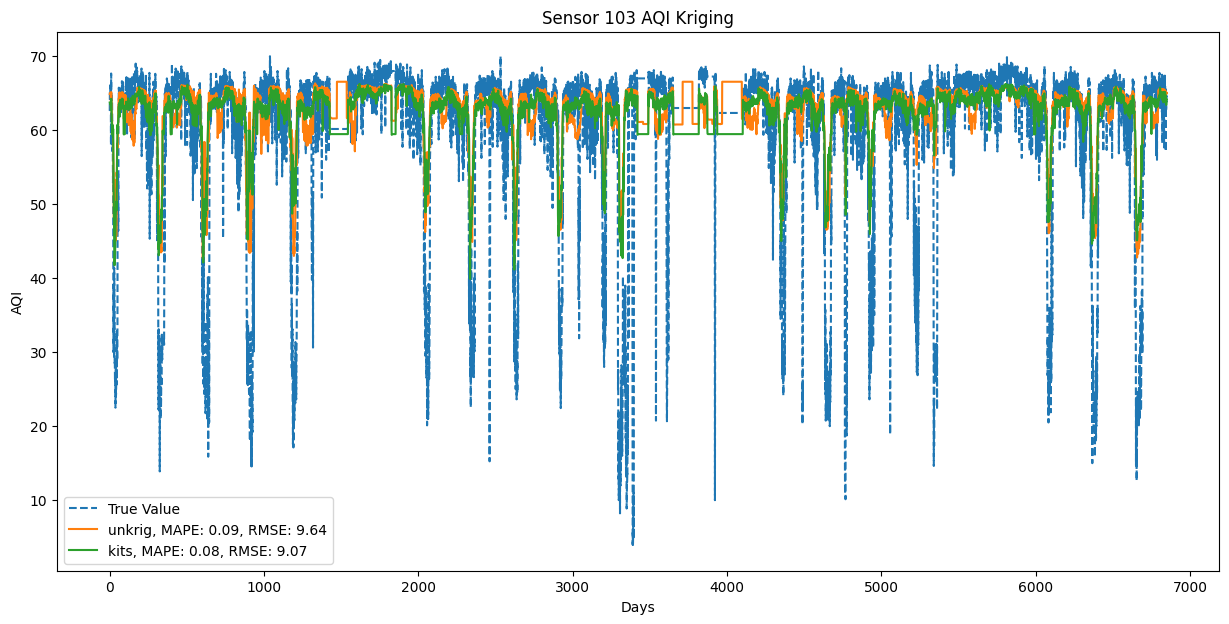

(6849, 24, 207, 1)
(6849, 24, 207, 1)


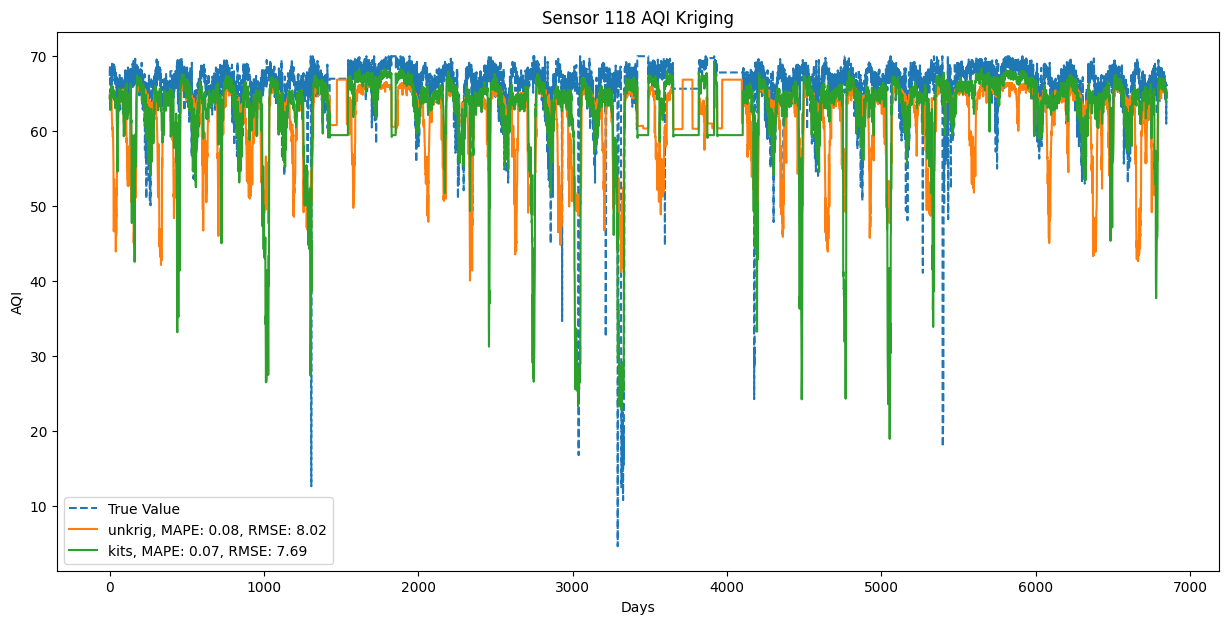

(6849, 24, 207, 1)
(6849, 24, 207, 1)


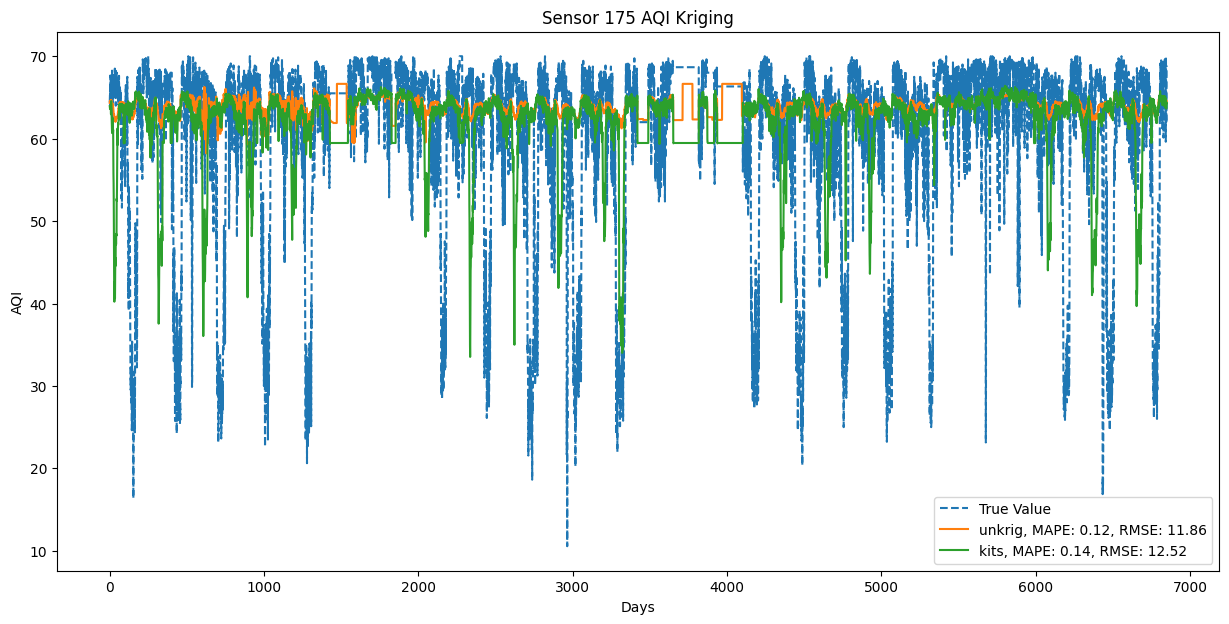

(6849, 24, 207, 1)
(6849, 24, 207, 1)


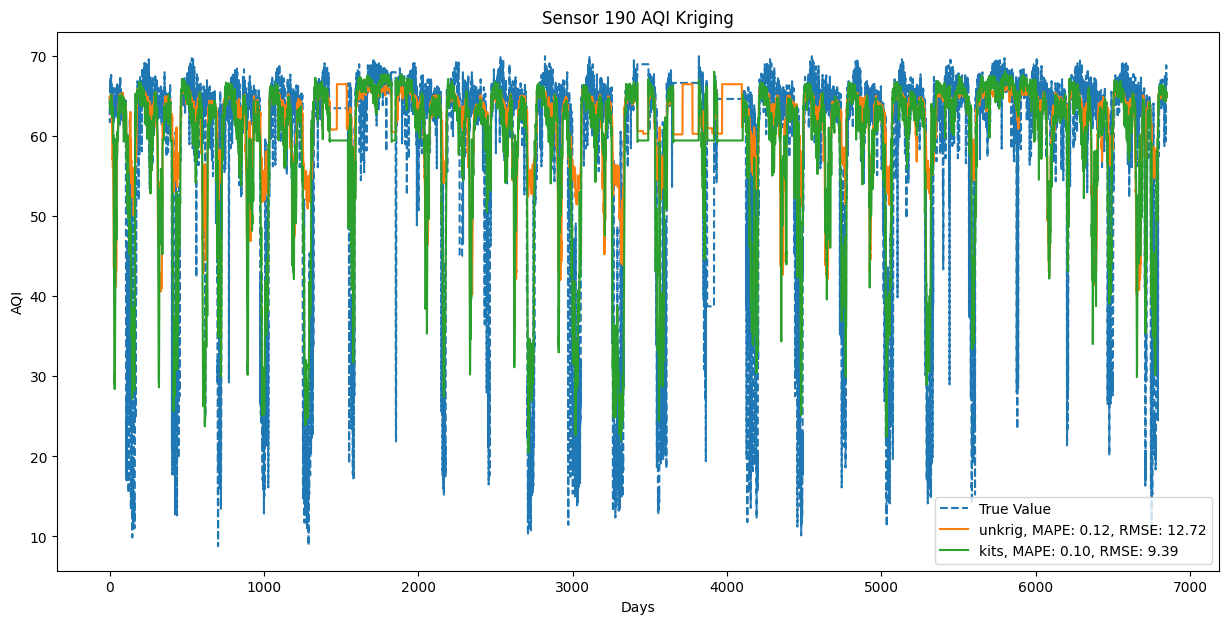

(6849, 24, 207, 1)
(6849, 24, 207, 1)


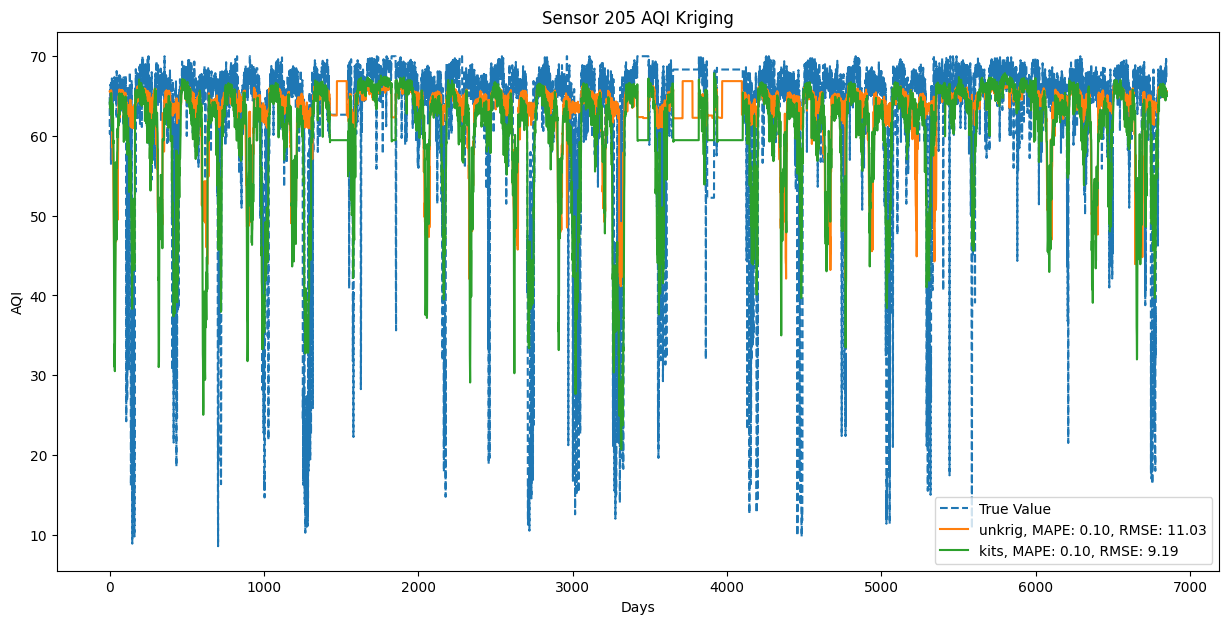

In [8]:
titles = ['unkrig', 'kits']
styles = ['-']
ranges = [0, -1]

sensors = [26, 126, 200, 21, 121, 18, 189, 50, 35, 182, 181, 180, 186, 59, 150, 8, 34, 185, 46, 66, 203, 149, 87, 100, 14, 86, 104, 112, 89, 151, 148, 172, 88, 202, 9, 51, 84, 204, 130, 41, 197, 77, 194, 43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
sensors = [43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
# sensors = [5, 10, 31, 40, 71, 73, 83, 117, 122, 156, 164, 176]
sensors = [3, 7, 10, 11, 12, 13, 15, 21, 24, 26, 27, 37, 38, 44, 51] #, 56, 57, 59, 61, 62, 64, 65, 67, 72, 74, 81, 86, 87, 92, 95, 98, 99, 106, 108, 112, 113, 116, 118, 124, 126, 127, 129, 133, 138, 140, 142, 144, 145, 149, 155, 168, 179, 183, 184, 185, 188, 191, 192, 196, 206]
sensors = [ 21, 156, 121,  35,  50, 200,  10, 179, 126, 189,  90,  18, 203,
            107,  44,  92, 183, 202, 152, 171,  99, 118,  45,   8,  55,  65]
sensors = [194, 125]
sensors = [74, 80, 91, 93, 94, 96, 97, 98, 102, 103, 118, 119, 124, 127, 128, 136, 138, 144]
        # 3, 4, 5, 6, 12, 15, 16, 17, 19, 20, 22, 32, 33, 39, 57, 67, 68, 71, 72,
        # 74, 80, 91, 93, 94, 96, 97, 98, 102, 103, 118, 119, 124, 127, 128, 136, 138, 144
        # 154, 155, 157, 159, 160, 161, 162, 163, 166, 175, 187, 188, 190, 191, 192, 193, 195, 196, 198, 205, 206]
# sensors = range(1, 11)

sensors = [119, 19, 20, 22, 39, 67, 68, 71, 72, 74, 94, 98, 102, 103, 118, 175, 190, 205]


# deets = [[y_hat, y_true, mask, res, dm, dataset]]
mape_deet = [0, 0]
rmse_deet = [0, 0]

for sensor in sensors:
    plt.figure(figsize=(15,7))
    y_true = deets[0][1]

    # y_true = np.where(deets[0][2] == 1, y_true, 400)

    plt.plot(y_true[ranges[0]:ranges[1], -1, sensor, :], '--', label='True Value')
    # plt.plot(deets[1][0][ranges[0]:ranges[1], 0, 33, :], '--', label='KITS')
    for ind, deet in enumerate(deets):
        # deet = deets[0]
        y_hat = deet[0]
        print(y_hat.shape)
        test_mape=numpy_metrics.mre(y_hat[ranges[0]:ranges[1], :, sensor, :], 
                                    y_true[ranges[0]:ranges[1], :, sensor, :])
        test_rmse=numpy_metrics.rmse(y_hat[ranges[0]:ranges[1], :, sensor, :], 
                                    y_true[ranges[0]:ranges[1], :, sensor, :])

    # if test_mre > 20:
        plt.plot(y_hat[ranges[0]:ranges[1], -1, sensor, :], label=f'{titles[ind]}, MAPE: {test_mape:.2f}, RMSE: {test_rmse:.2f}')
        mape_deet[ind] += test_mape
        rmse_deet[ind] += test_rmse
        # plt.plot(deet[1][ranges[0]:ranges[1], 0, 4, :], label=f'True Value')

    # plt.ylim((0, 100))
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.legend()
    plt.title(f'Sensor {sensor} AQI Kriging')
    plt.show()